## Exercici 1
Realitza web scraping d'una pàgina de la borsa de Madrid (https://www.bolsamadrid.es) utilitzant BeautifulSoup i Selenium.

**BeautifulSoup**

En primer lugar, inspecciono el contenido de la página web

In [2]:
import requests

URL = "https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice"
page = requests.get(URL)

print(page.text)


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head data-idioma="esp" data-hora-act="Tue, 05 Apr 2022 18:07:43 GMT" data-app-path="/" data-bolsa="BMadrid" data-analytics-id="UA-35966870-2"><meta http-equiv="X-UA-Compatible" content="IE=11" /><meta http-equiv="Content-Type" content="text/html; charset=UTF-8" /><meta id="ctl00_copyright" name="copyright" content="Copyright © BME 2022" /><title>
	Bolsa de Madrid - Precios Sesión
</title><link id="ctl00_RSSLink1" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=Todo" title="Bolsa de Madrid: Todos los contenidos agregados" /><link id="ctl00_RSSLink2" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=NotasPrensa" title="Bolsa de Madrid: Notas de Prensa" /><link id="ctl00_RSSLink3" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=Regulacion" 

Decido la información que quiero obtener, el conjunto de diferencias de precios de las empresas del IBEX35

In [3]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(page.content, "html.parser")

Localizo las clases HTML que me interesan y recojo la información. Aprovecho para comprobar que todos los datos que necesito están presentes y que no hay datos extra

In [4]:
empresas = soup.find_all("td", class_="DifFlBj")
difs = soup.find_all("td", class_="DifClBj")

empresas_bj = []
for empresa in empresas:
    empresas_bj.append(empresa.text.strip())

print(len(empresas_bj), empresas_bj)

difs_bj = []
for dif in difs:
    difs_bj.append(dif.text.strip())
    
print(len(difs_bj), difs_bj)

9 ['ACERINOX', 'ARCELORMIT.', 'B.SANTANDER', 'BA.SABADELL', 'BBVA', 'CIE AUTOMOT.', 'FERROVIAL', 'IAG', 'INDRA A']
10 ['-1,04', '-1,96', '-3,77', '-1,57', '-1,27', '-1,35', '-3,35', '-0,74', '-0,27', '-1,30']


In [5]:
empresas = soup.find_all("td", class_="DifFlSb")
difs = soup.find_all("td", class_="DifClSb")

empresas_sb = []
for empresa in empresas:
    empresas_sb.append(empresa.text.strip())

print(len(empresas_sb), empresas_sb)

difs_sb = []
for dif in difs:
    difs_sb.append(dif.text.strip())
    
print(len(difs_sb), difs_sb)

25 ['IBEX 35®', 'ACCIONA', 'ACS', 'ALMIRALL', 'AMADEUS', 'BANKINTER', 'CAIXABANK', 'CELLNEX', 'ENAGAS', 'ENDESA', 'FLUIDRA', 'GRIFOLS CL.A', 'IBERDROLA', 'INDITEX', 'INM.COLONIAL', 'MAPFRE', 'MELIA HOTELS', 'NATURGY', 'PHARMA MAR', 'R.E.C.', 'REPSOL', 'ROVI', 'SIEMENS GAME', 'SOLARIA', 'TELEFONICA']
25 ['1,20', '3,04', '0,62', '2,66', '0,54', '0,19', '0,41', '4,17', '1,14', '2,86', '2,18', '0,81', '4,54', '0,75', '0,91', '1,72', '0,08', '3,09', '2,06', '2,76', '2,61', '2,51', '6,83', '6,33', '1,38']


Compruebo que, junto a la información relativa a las empresas, se incluye información del IBEX35 en conjunto (el nombre, IBEX35 y dos precios relativos a la media anual y la de ese momento).

Por tanto, elimino de la colección de datos la información general del IBEX35. Primero el nombre:

In [6]:
# Averiguar si el IBEX ha subido o ha bajado
if "IBEX 35®" in empresas_sb:
    print(empresas_sb)
    index = empresas_sb.index("IBEX 35®")
    empresas_sb.remove("IBEX 35®")
    print(empresas_sb)
elif "IBEX 35®" in empresas_bj:
    print(empresas_bj)
    index = empresas_bj.index("IBEX 35®")
    empresas_bj.remove("IBEX 35®")
    print(empresas_bj)

['IBEX 35®', 'ACCIONA', 'ACS', 'ALMIRALL', 'AMADEUS', 'BANKINTER', 'CAIXABANK', 'CELLNEX', 'ENAGAS', 'ENDESA', 'FLUIDRA', 'GRIFOLS CL.A', 'IBERDROLA', 'INDITEX', 'INM.COLONIAL', 'MAPFRE', 'MELIA HOTELS', 'NATURGY', 'PHARMA MAR', 'R.E.C.', 'REPSOL', 'ROVI', 'SIEMENS GAME', 'SOLARIA', 'TELEFONICA']
['ACCIONA', 'ACS', 'ALMIRALL', 'AMADEUS', 'BANKINTER', 'CAIXABANK', 'CELLNEX', 'ENAGAS', 'ENDESA', 'FLUIDRA', 'GRIFOLS CL.A', 'IBERDROLA', 'INDITEX', 'INM.COLONIAL', 'MAPFRE', 'MELIA HOTELS', 'NATURGY', 'PHARMA MAR', 'R.E.C.', 'REPSOL', 'ROVI', 'SIEMENS GAME', 'SOLARIA', 'TELEFONICA']


 Y luego sus dos precios, tanto si indican incremento como disminución

In [7]:
print(len(empresas_sb), len(difs_sb))

while len(empresas_sb) < len(difs_sb):
    difs_sb.remove(f"{difs_sb[0]}")
    
print(len(empresas_sb), len(difs_sb))

24 25
24 24


In [8]:
print(len(empresas_bj), len(difs_bj))

while len(empresas_bj) < len(difs_bj):
    index= difs_bj[0]
    difs_bj.remove(f"{difs_bj[0]}")
    
print(len(empresas_bj), len(difs_bj))

9 10
9 9


De esta manera, las longitudes de todas las listas de datos (empresas y precios) cuadran y puedo estudiar los datos y trabajar con ellos. Primero creo un dataframe:

In [9]:
import pandas as pd

df_ibex = pd.DataFrame()

df_ibex["Empresa"] = empresas_bj + empresas_sb
df_ibex["Dif"] = difs_bj + difs_sb
df_ibex = df_ibex.sort_values(by=['Empresa'])

display(df_ibex)

,Empresa,Dif
9,ACCIONA,"3,04"
0,ACERINOX,"-1,96"
10,ACS,"0,62"
11,ALMIRALL,"2,66"
12,AMADEUS,"0,54"
1,ARCELORMIT.,"-3,77"
2,B.SANTANDER,"-1,57"
3,BA.SABADELL,"-1,27"
13,BANKINTER,"0,19"
4,BBVA,"-1,35"


In [10]:
df_ibex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 9 to 32
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Empresa  33 non-null     object
 1   Dif      33 non-null     object
dtypes: object(2)
memory usage: 792.0+ bytes


Convierto la columna Dif, los precios, a float

In [11]:
df_ibex['Dif'] = df_ibex['Dif'].str.replace(',','.')
df_ibex['Dif'] = pd.to_numeric(df_ibex['Dif'])
df_ibex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 9 to 32
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Empresa  33 non-null     object 
 1   Dif      33 non-null     float64
dtypes: float64(1), object(1)
memory usage: 792.0+ bytes


Y visualizo los datos en un gráfico:

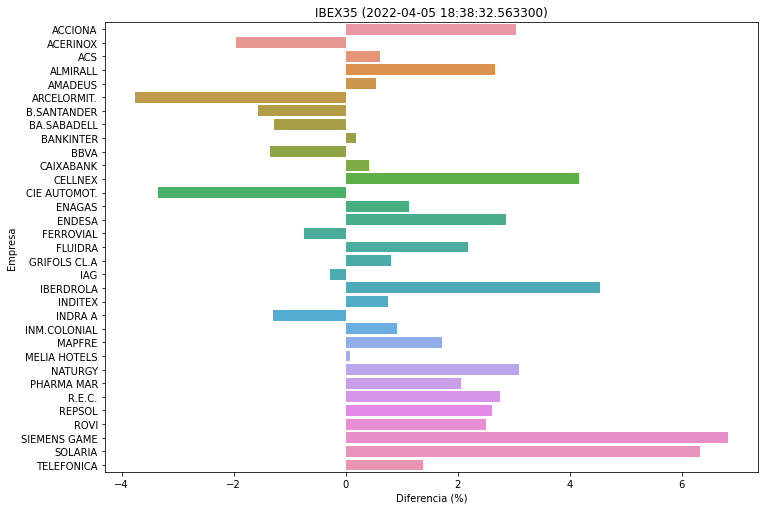

In [47]:
from matplotlib import pyplot as plt
import seaborn
from datetime import datetime

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
seaborn.barplot(x="Dif", y="Empresa", data=df_ibex)
plt.title(f"IBEX35 ({datetime.date(datetime.now())} {datetime.time(datetime.now())})")
plt.xlabel("Diferencia (%)")
plt.ylabel("Empresa")
plt.show()

**Selenium**

In [48]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from collections import namedtuple
from os.path import isfile
from threading import Thread
import csv
from time import sleep
from datetime import datetime


BOLSA_PRECIOSIBEX ='https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice'
precios_sesion = namedtuple('precios_sesion', ['company', 'dif', 'timestamp'])


class PreciosIbex():
    def __init__(self):

        options = webdriver.ChromeOptions()
        options.add_argument("--start-maximized")
        options.add_argument('--log-level=3')
        options.add_argument('--headless')

        self.driver = webdriver.Chrome(
            executable_path="chromedriver",
            options=options
        )
        self.driver.get(BOLSA_PRECIOSIBEX)

        self.empresas_sb = []
        self.empresas_bj = []
        self.difs_sb = []
        self.difs_bj = []
        
        self.empresas_all = []
        self.difs_all = []
        self.horas = []
        
        self.df_ibex = pd.DataFrame()
        
        self.datos()
                
        self.fecha = datetime.date(datetime.now())
        self.database_path= f"precios_IBEX35_{self.fecha}.csv"
        self.database = []
        
        if isfile(self.database_path):
            with open(self.database_path, newline='') as dbfile:
                dbreader = csv.reader(dbfile)
                next(dbreader)
        
        self.thread = Thread(target=self.maintain)
        self.thread.daemon = True 
        self.thread.start()
        
    
    def maintain(self):
        while True:
            self.datos()
            self.update_db()
            sleep(20)
    
    
    def save_db(self):
        with open(self.database_path,'w', newline='') as dbfile:
            dbwriter = csv.writer(dbfile)
            dbwriter.writerow(list(precios_sesion._fields))
            for entry in self.database:
                dbwriter.writerow(list(entry))
                

    def update_db(self):
        check = ((
            (len(self.empresas_sb) > 0 and len(self.difs_sb) > 0) 
            or 
            (len(self.empresas_bj) > 0 and len(self.difs_bj) > 0)
        ))

        if check:
            for i in range(len(self.empresas_all)):
                self.database.append([self.empresas_all[i], self.difs_all[i], self.horas[i]])
                self.save_db()

        
    def datos(self):
        '''
        Recabar información de la página relativa a cambios en el IBEX
        '''
        self.driver.get(BOLSA_PRECIOSIBEX)
        empresas_sb = self.driver.find_elements(By.CLASS_NAME,'DifFlSb')
        empresas_bj = self.driver.find_elements(By.CLASS_NAME,'DifFlBj')
        difs_sb = self.driver.find_elements(By.CLASS_NAME,'DifClSb')
        difs_bj = self.driver.find_elements(By.CLASS_NAME,'DifClBj')
        horas = self.driver.find_elements(By.CLASS_NAME,'Ult')
        
        self.empresas_sb = [i.text for i in empresas_sb]
        self.empresas_bj = [i.text for i in empresas_bj]
        self.difs_sb = [i.text for i in difs_sb]
        self.difs_bj = [i.text for i in difs_bj]
        self.horas = [i.text for i in horas]
        
        self.eliminar_info_gral_IBEX()
        self.convertir_float()
    
    
    def eliminar_info_gral_IBEX(self):
              
        if "IBEX 35®" in self.empresas_sb:
            self.empresas_sb.remove("IBEX 35®")
        elif "IBEX 35®" in self.empresas_bj:
            self.empresas_bj.remove("IBEX 35®")

        while len(self.empresas_sb) < len(self.difs_sb):
            self.difs_sb.remove(f"{self.difs_sb[0]}")
        while len(self.empresas_bj) < len(self.difs_bj):
            self.difs_bj.remove(f"{self.difs_bj[0]}")
        
        self.empresas_all = self.empresas_sb + self.empresas_bj        
        self.difs_all = self.difs_sb + self.difs_bj
        
        while len(self.difs_all) < len(self.horas):
            self.horas.remove(f"{self.horas[0]}")
        
        
    def convertir_float(self):
        floated_difs = []
        for dif in self.difs_all:
            dif = dif.replace(",", ".")
            dif = float(dif)
            floated_difs.append(dif)
        self.difs_all = floated_difs
        
        
    def crear_tabla(self):
        self.df_ibex["Empresa"] = self.empresas_bj + self.empresas_sb
        self.df_ibex["Dif"] = self.difs_bj + self.difs_sb
        self.df_ibex['Dif'] = self.df_ibex['Dif'].str.replace(',','.')
        self.df_ibex['Dif'] = pd.to_numeric(self.df_ibex['Dif'])
        self.df_ibex['Hora'] = self.horas
        
        
    def ver_grafico(self):
        self.crear_tabla()
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        seaborn.barplot(x="Dif", y="Empresa", data=df_ibex)
        plt.title(f"IBEX35 ({self.fecha} {datetime.time(datetime.now())})")
        plt.xlabel("Diferencia (%)")
        plt.ylabel("Empresa")
        
    
    def ver_datos(self):
        self.crear_tabla()
        display(self.df_ibex)
    

In [52]:
precios_ibex = PreciosIbex()

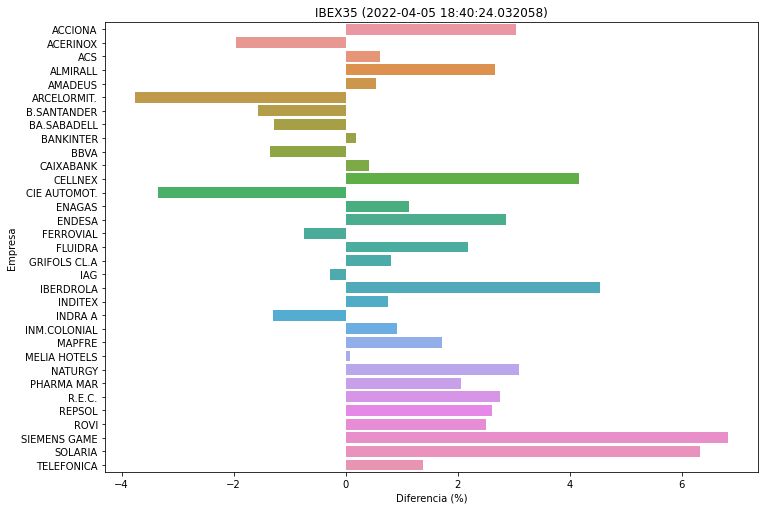

In [53]:
precios_ibex.ver_grafico()

In [42]:
precios_ibex.ver_datos()

,Empresa,Dif,Hora
0,ACERINOX,-1.96,Cierre
1,ARCELORMIT.,-3.77,Cierre
2,B.SANTANDER,-1.57,Cierre
3,BA.SABADELL,-1.27,Cierre
4,BBVA,-1.35,Cierre
5,CIE AUTOMOT.,-3.35,Cierre
6,FERROVIAL,-0.74,Cierre
7,IAG,-0.27,Cierre
8,INDRA A,-1.30,Cierre
9,ACCIONA,3.04,Cierre


Visualizo los datos recogidos. Primero preproceso la columna de timestamp para trabajar con las horas sin segundos.

In [61]:
import pandas as pd

df_precios_ibex = pd.read_csv('precios_IBEX35_2022-04-05.csv')

df_precios_ibex['timestamp'] = pd.to_datetime(df_precios_ibex['timestamp'], format='%H:%M:%S')
df_precios_ibex['time'] = df_precios_ibex['timestamp'].dt.strftime('%H:%M')
display(df_precios_ibex['time'])

0       15:44
1       15:44
2       15:44
3       15:39
4       15:44
        ...  
2843    16:14
2844    16:13
2845    16:14
2846    16:14
2847    16:14
Name: time, Length: 2848, dtype: object

Luego selecciono dos compañías que me interesan para comprobar cómo han variado sus precios en media hora

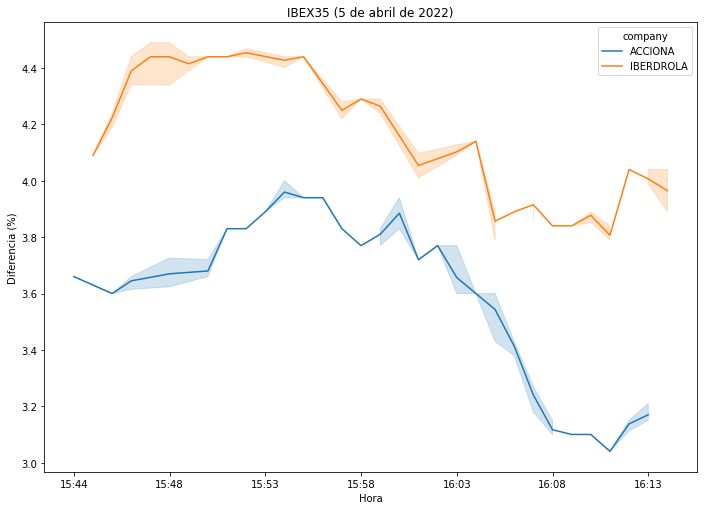

In [62]:
import seaborn as sns
import matplotlib.ticker as ticker

df_precios_ibex_acciona_iberdrola = df_precios_ibex[(df_precios_ibex['company']=='ACCIONA') | 
                                                    (df_precios_ibex['company']=='IBERDROLA')]

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(data=df_precios_ibex_acciona_iberdrola, y="dif", x="time", hue="company")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title("IBEX35 (5 de abril de 2022)")
plt.xlabel("Hora")
plt.ylabel("Diferencia (%)")
plt.show()

## Exercici 2
Documenta en un word el teu conjunt de dades generat amb la informació que tenen els diferents arxius de Kaggle.

In [35]:
from IPython.display import IFrame
IFrame("documentation.pdf", width=900, height=600)


## Exercici 3
Tria una página web que tu vulguis i realitza web scraping mitjançant la llibreria Scrapy

**Scrapy**

He elegido la web https://seo.org/listado-aves-2/, y mi objetivo es obtener los nombres, común y científico, de aves de España.

En primer lugar, creo un pipeline, una clase que se encargará de convertir los nombres recabados a un archivo JSON donde cada línea se corresponde con un ave.

In [19]:
import scrapy
from scrapy.crawler import CrawlerProcess
import json


class JsonWriterPipeline(object):

    def open_spider(self, spider):
        self.file = open('birds_results.json', 'w')

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

Después, defino la Spider y su comportamiento. Determino el tipo de datos que debe recoger de acuerdo con las etiquetas HTML donde se alojan, los paso al documento json y de ahí los transformo en un documento .csv.

In [20]:
import logging
from string import ascii_uppercase


class BirdSpider(scrapy.Spider):
    name = "birds"
    start_urls = [
        # Como los nombres de aves están ordenados alfabéticamente, itero por las páginas de todas las letras
        f'https://seo.org/listado-aves-2/?letra={letter}' for letter in ascii_uppercase
    ]
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, # Used for pipeline 1
        'FEEDS':{
            'birds_results.csv':{
                'format':'csv',
                'overwrite': True,
                'encoding': 'utf8'
            }
        }
    }
    
    def parse(self, response):
        for bird in response.css('div.contenedor_txt'):
            yield {
                'namme_common': bird.css('h3 a::text').extract_first(),
                'name_scientific': bird.css('p::text').extract_first(),
            }

Ejecuto la Spider

In [21]:
import sys
from twisted.internet import default

# Permite ejecutar este mismo bloque de código sin que genere "reactoralreadyinstalled.error"
if 'twisted.internet.reactor' in sys.modules:
    del sys.modules['twisted.internet.reactor']

    
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(BirdSpider)
process.start()

2022-04-05 18:07:57 [scrapy.utils.log] INFO: Scrapy 2.6.1 started (bot: scrapybot)
2022-04-05 18:07:57 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 22.2.0, Python 3.9.7 (default, Sep 16 2021, 08:50:36) - [Clang 10.0.0 ], pyOpenSSL 21.0.0 (OpenSSL 1.1.1l  24 Aug 2021), cryptography 3.4.8, Platform macOS-10.16-x86_64-i386-64bit
2022-04-05 18:07:57 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 30,
 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}


Compruebo el contenido del documento .csv generado

In [22]:
import pandas as pd

df_birds = pd.read_csv('birds_results.csv')
display(df_birds)

,namme_common,name_scientific
0,Halcón de Eleonora,Falco eleonorae
1,Halcón peregrino,Falco peregrinus
2,Halcón tagarote,Falco pelegrinoides
3,Herrerillo canario,Cyanistes teneriffae
4,Herrerillo capuchino,Lophophanes cristatus
...,...,...
351,Zarcero políglota,Hippolais polyglotta
352,Zorzal alirrojo,Turdus iliacus
353,Zorzal charlo,Turdus viscivorus
354,Zorzal común,Turdus philomelos
